Общая цель:

Поэтапная разработка кастомной ResNet18 модели для классификации Tiny ImageNet с анализом влияния различных архитектурных решений на производительность.

Датасет: Tiny ImageNet (200 классов) - выберите 10 классов самостоятельно для работы


Часть 1: Подготовка данных

In [1]:
!unzip -q /content/tiny-imagenet-200.zip -d /content/

In [2]:
SELECTED_CLASSES = [
    'n01629819',  # salamander
    'n00006400',	# biont
    'n01742172',  # black widow
    'n01882714',  # koala
    'n01768244',  # trilobite
    'n00029378',	# event
    'n02085620',  # chihuahua
    'n00006269',	# life
    'n01774750',  # tarantula
    'n02123045',  # tabby cat
]



Создание датакласса

In [3]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import glob

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, selected_classes, split='train', transform=None):
        """
        Args:
            root_dir: путь к корневой директории Tiny ImageNet
            selected_classes: список ID классов
            split: 'train' или 'val'
            transform: трансформации для изображений
        """
        self.root_dir = root_dir
        self.selected_classes = selected_classes
        self.split = split
        self.transform = transform

        # Маппинг класс -> индекс
        self.class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}

        # Инициализация путей к данным, загрузка списка изображений и меток
        self.image_paths = []
        self.labels = []

        if split == 'train':
            self._load_train_data()
        elif split == 'val':
            self._load_val_data()

    def _load_train_data(self):
        train_dir = os.path.join(self.root_dir, 'train')

        for class_id in self.selected_classes:
            class_dir = os.path.join(train_dir, class_id, 'images')
            image_files = glob.glob(os.path.join(class_dir, '*.JPEG'))

            for img_path in image_files:
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[class_id])

    def _load_val_data(self):
        val_dir = os.path.join(self.root_dir, 'val')
        val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

        with open(val_annotations_file, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                img_name = parts[0]
                class_id = parts[1]

                if class_id in self.selected_classes:
                    img_path = os.path.join(val_dir, 'images', img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_id])

    def __len__(self):
        """Возврат количества примеров в датасете"""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Загрузка и возврат одного примера (изображение + метка)"""
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

Часть 2: Базовая архитектура ResNet18
2.1. Реализация Basic Block
Создайте базовый residual блок со следующей структурой:

Input
  ↓
Conv2d(kernel_size=3, padding=1, stride=stride)
  ↓
BatchNorm2d
  ↓
ReLU
  ↓
Conv2d(kernel_size=3, padding=1, stride=1)
  ↓
BatchNorm2d
  ↓
  + ← Skip Connection (с возможностью downsample)
  ↓
ReLU
  ↓
Output
Важно:

Если входные и выходные размерности не совпадают, используйте skip connection с Conv2d(1x1) + BatchNorm2d
Первый residual блок может иметь stride=2 для уменьшения пространственного размера

In [4]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

2.2. Реализация ResNet18
Создайте архитектуру ResNet18 со следующей структурой:

Input (3, 64, 64)
  ↓
Conv2d(3→64, kernel_size=7, stride=2, padding=3)  # или 3x3, stride=1 для Tiny ImageNet
  ↓
BatchNorm2d
  ↓
ReLU
  ↓
MaxPool2d(kernel_size=3, stride=2, padding=1)  # опционально для Tiny ImageNet
  ↓
Layer1: 2x Basic Block (64 channels)
  ↓
Layer2: 2x Basic Block (128 channels, stride=2 в первом блоке)
  ↓
Layer3: 2x Basic Block (256 channels, stride=2 в первом блоке)
  ↓
Layer4: 2x Basic Block (512 channels, stride=2 в первом блоке)  # ОПЦИОНАЛЬНО
  ↓
AdaptiveAvgPool2d(output_size=(1, 1))
  ↓
Flatten
  ↓
Linear(512 → 10)  # 10 классов
  ↓
Output
2.3. Ограничения для базовой модели:
Общее количество параметров: не более 5 миллионов
Максимальное количество каналов: до 512


In [5]:


class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []

        layers.append(BasicBlock(in_channels, out_channels, stride))

        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def count_parameters(model):
    """Подсчет общего количества параметров модели"""
    return sum(p.numel() for p in model.parameters())

model = ResNet18(num_classes=10)

total_params = count_parameters(model)
print(f"Общее количество параметров: {total_params:,} ({total_params/1e6:.2f}M)")



Общее количество параметров: 2,777,674 (2.78M)


2.4. Скрипт обучения
Реализуйте цикл обучения с следующими компонентами:

Оптимизатор:

Adam или SGD
Learning rate: 0.001
Loss function:

CrossEntropyLoss
Метрики:

Accuracy для train/validation
Loss для train/validation
Обучение:

Количество эпох: 20-30
Логирование метрик на каждой эпохе

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Обучение на одной эпохе"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Валидация модели"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001, device='cuda'):
    """Полный цикл обучения"""
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return history

TINY_IMAGENET_PATH = '/content/tiny-imagenet-200'

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TinyImageNetDataset(TINY_IMAGENET_PATH, SELECTED_CLASSES, 'train', train_transform)
val_dataset = TinyImageNetDataset(TINY_IMAGENET_PATH, SELECTED_CLASSES, 'val', val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используется устройство: {device}')

model = ResNet18(num_classes=10)
print(f'Количество параметров: {count_parameters(model):,}')

history = train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

Используется устройство: cuda
Количество параметров: 2,777,674
Epoch [1/20] Train Loss: 1.7734, Train Acc: 31.40% | Val Loss: 2.2112, Val Acc: 22.00%
Epoch [2/20] Train Loss: 1.5073, Train Acc: 43.00% | Val Loss: 1.7345, Val Acc: 36.57%
Epoch [3/20] Train Loss: 1.3860, Train Acc: 48.66% | Val Loss: 1.4724, Val Acc: 45.43%
Epoch [4/20] Train Loss: 1.2802, Train Acc: 53.31% | Val Loss: 1.7689, Val Acc: 38.86%
Epoch [5/20] Train Loss: 1.2289, Train Acc: 54.60% | Val Loss: 1.8481, Val Acc: 40.57%
Epoch [6/20] Train Loss: 1.1285, Train Acc: 58.80% | Val Loss: 1.5981, Val Acc: 46.29%
Epoch [7/20] Train Loss: 1.0921, Train Acc: 62.06% | Val Loss: 1.8207, Val Acc: 48.00%
Epoch [8/20] Train Loss: 1.0170, Train Acc: 63.91% | Val Loss: 1.6966, Val Acc: 44.86%
Epoch [9/20] Train Loss: 0.9513, Train Acc: 66.60% | Val Loss: 1.3097, Val Acc: 57.43%
Epoch [10/20] Train Loss: 0.9144, Train Acc: 67.34% | Val Loss: 1.5426, Val Acc: 48.00%
Epoch [11/20] Train Loss: 0.8318, Train Acc: 70.63% | Val Loss: 1.

2.5: Визуализация базовых результатов
После обучения базовой модели создайте:

График Accuracy:

X: эпохи
Y: accuracy
Две линии: train и validation
График Loss:

X: эпохи
Y: loss
Две линии: train и validation
Информация о модели:

Общее количество параметров
Архитектура (выведите через print(model))

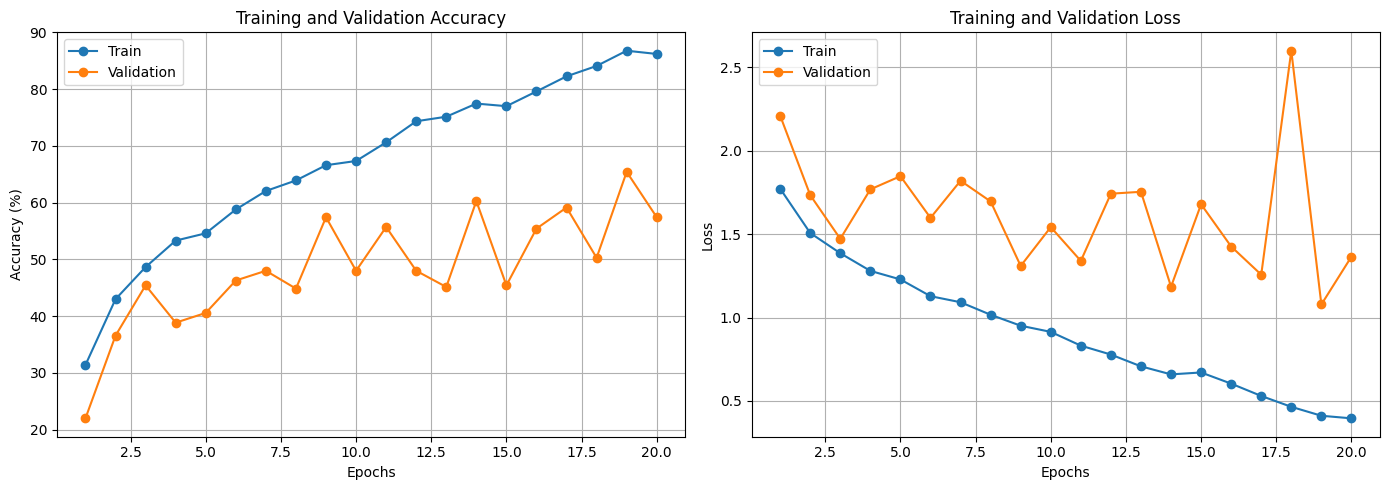

Общее количество параметров: 2,777,674

Архитектура модели:
ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64

In [7]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(epochs, history['train_acc'], label='Train', marker='o')
    ax1.plot(epochs, history['val_acc'], label='Validation', marker='o')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, history['train_loss'], label='Train', marker='o')
    ax2.plot(epochs, history['val_loss'], label='Validation', marker='o')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_results(history)

print(f"Общее количество параметров: {count_parameters(model):,}")
print("\nАрхитектура модели:")
print(model)

Часть 3: Поэтапная оптимизация модели
3.1: Оптимизация количества каналов
Цель: Изучение влияния количества каналов на производительность.

Эксперимент:

Создайте 2 варианта модели:
Вариант A: 32 → 64 → 128 → 256 каналов
Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)
Обучите обе модели с теми же гиперпараметрами
Сравните:
Количество параметров
Validation accuracy
Результат:

Таблица сравнения
Графики accuracy и loss для обоих вариантов
Вывод: какая конфигурация лучше?

ВАРИАНТ A:
Количество параметров: 2,797,610
Epoch [1/20] Train Loss: 1.6824, Train Acc: 35.00% | Val Loss: 1.6536, Val Acc: 36.57%
Epoch [2/20] Train Loss: 1.3840, Train Acc: 47.71% | Val Loss: 1.8200, Val Acc: 37.71%
Epoch [3/20] Train Loss: 1.2136, Train Acc: 55.37% | Val Loss: 1.8468, Val Acc: 44.57%
Epoch [4/20] Train Loss: 1.0853, Train Acc: 61.71% | Val Loss: 1.3716, Val Acc: 53.14%
Epoch [5/20] Train Loss: 0.9717, Train Acc: 65.17% | Val Loss: 1.4970, Val Acc: 48.57%
Epoch [6/20] Train Loss: 0.8926, Train Acc: 68.43% | Val Loss: 1.4065, Val Acc: 57.14%
Epoch [7/20] Train Loss: 0.7846, Train Acc: 72.89% | Val Loss: 3.3043, Val Acc: 33.71%
Epoch [8/20] Train Loss: 0.6976, Train Acc: 76.06% | Val Loss: 2.7999, Val Acc: 31.43%
Epoch [9/20] Train Loss: 0.5284, Train Acc: 82.11% | Val Loss: 2.6404, Val Acc: 42.29%
Epoch [10/20] Train Loss: 0.4431, Train Acc: 84.86% | Val Loss: 2.3104, Val Acc: 39.71%
Epoch [11/20] Train Loss: 0.3283, Train Acc: 88.69% | Val Loss: 1.7954, Val Acc: 50.5

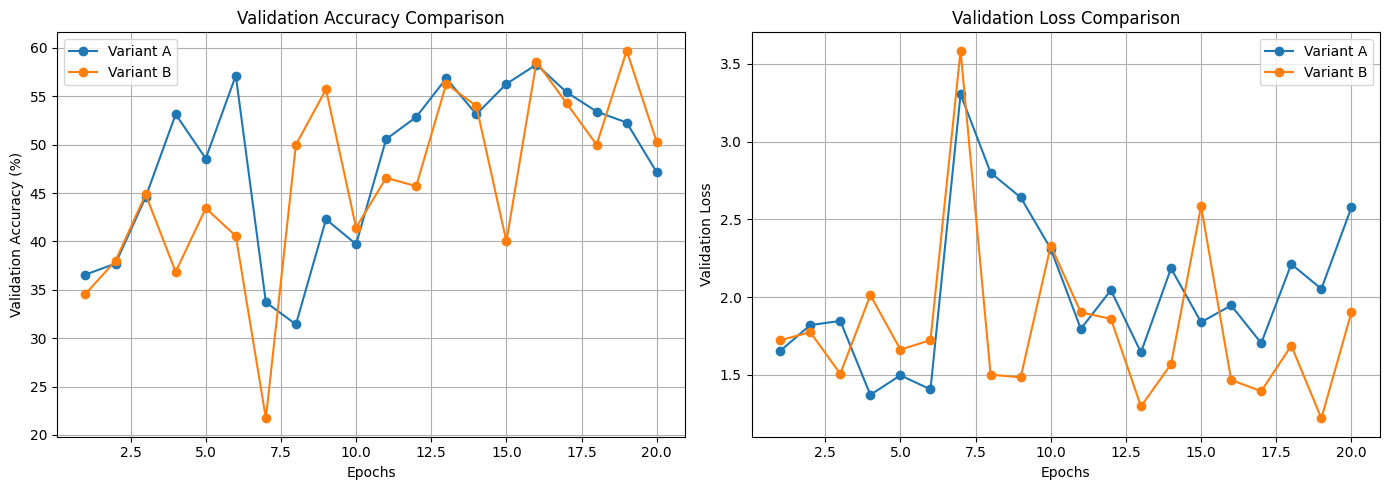

In [8]:
class ResNet18_VariantA(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_VariantA, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(32, 32, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(32, 64, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(128, 256, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

class ResNet18_VariantB(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_VariantB, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

print("ВАРИАНТ A:")
model_A = ResNet18_VariantA(num_classes=10)
print(f'Количество параметров: {count_parameters(model_A):,}')

history_A = train_model(model_A, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("ВАРИАНТ B:")
model_B = ResNet18_VariantB(num_classes=10)
print(f'Количество параметров: {count_parameters(model_B):,}')

history_B = train_model(model_B, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print(f"Вариант A - Параметры: {count_parameters(model_A):,}, Val Accuracy: {max(history_A['val_acc']):.2f}%")
print(f"Вариант B - Параметры: {count_parameters(model_B):,}, Val Accuracy: {max(history_B['val_acc']):.2f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history_A['train_acc']) + 1)

# Accuracy
ax1.plot(epochs, history_A['val_acc'], label='Variant A', marker='o')
ax1.plot(epochs, history_B['val_acc'], label='Variant B', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Accuracy (%)')
ax1.set_title('Validation Accuracy Comparison')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(epochs, history_A['val_loss'], label='Variant A', marker='o')
ax2.plot(epochs, history_B['val_loss'], label='Variant B', marker='o')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss Comparison')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Вывод: вариант B показывает лучший результат с тз валидационной точности, поэтому используем эту конфигурацию.

3.2: Эксперименты с количеством residual блоков
Цель: Изучение влияния глубины сети (количества residual блоков) на производительность.

Эксперимент:

Используйте лучшую конфигурацию каналов из Этапа 3.1
Создайте 3 варианта модели с разным количеством блоков в каждом слое:
Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)
Вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)
Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)
Обучите все три модели с одинаковыми гиперпараметрами

ВАРИАНТ A:
Количество параметров: 1,227,594
Epoch [1/20] Train Loss: 1.7631, Train Acc: 31.34% | Val Loss: 2.0784, Val Acc: 25.71%
Epoch [2/20] Train Loss: 1.4897, Train Acc: 44.86% | Val Loss: 1.7256, Val Acc: 37.43%
Epoch [3/20] Train Loss: 1.3811, Train Acc: 49.14% | Val Loss: 1.4995, Val Acc: 46.86%
Epoch [4/20] Train Loss: 1.2867, Train Acc: 52.89% | Val Loss: 1.4530, Val Acc: 42.00%
Epoch [5/20] Train Loss: 1.2080, Train Acc: 57.43% | Val Loss: 2.8295, Val Acc: 36.00%
Epoch [6/20] Train Loss: 1.1401, Train Acc: 59.31% | Val Loss: 1.4192, Val Acc: 47.71%
Epoch [7/20] Train Loss: 1.0572, Train Acc: 62.83% | Val Loss: 1.5421, Val Acc: 47.71%
Epoch [8/20] Train Loss: 1.0279, Train Acc: 64.20% | Val Loss: 1.6437, Val Acc: 46.00%
Epoch [9/20] Train Loss: 0.9674, Train Acc: 65.91% | Val Loss: 1.8675, Val Acc: 43.71%
Epoch [10/20] Train Loss: 0.9369, Train Acc: 68.06% | Val Loss: 1.2747, Val Acc: 53.43%
Epoch [11/20] Train Loss: 0.8891, Train Acc: 69.51% | Val Loss: 1.2292, Val Acc: 53.1

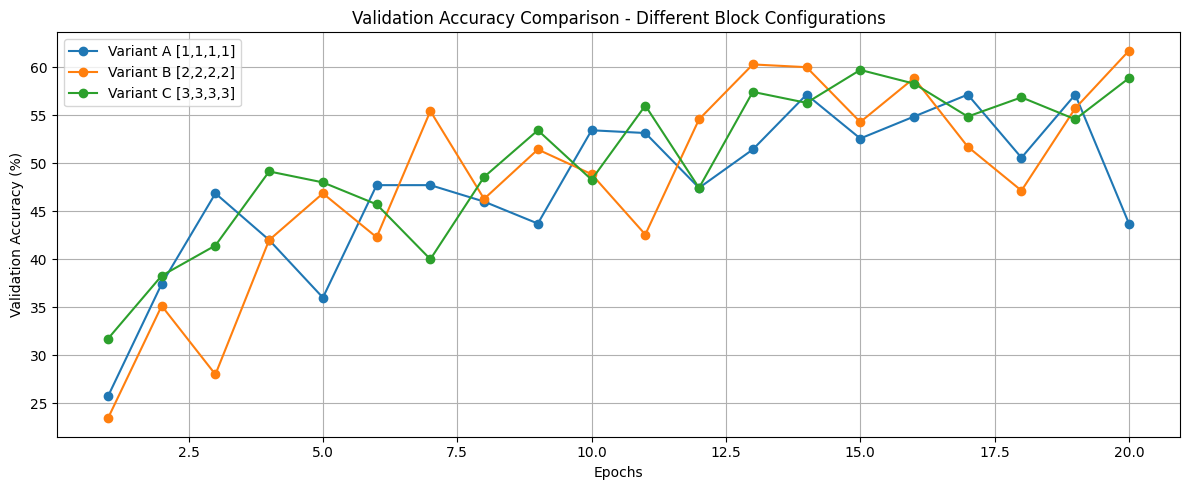

In [9]:
class ResNet18_Flexible(nn.Module):
    def __init__(self, num_classes=10, num_blocks=[2, 2, 2, 2]):
        super(ResNet18_Flexible, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(64, 64, num_blocks=num_blocks[0], stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=num_blocks[1], stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=num_blocks[2], stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)


        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое
print("ВАРИАНТ A:")
model_blocks_A = ResNet18_Flexible(num_classes=10, num_blocks=[1, 1, 1, 1])
print(f'Количество параметров: {count_parameters(model_blocks_A):,}')

history_blocks_A = train_model(model_blocks_A, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

# Вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое
print("ВАРИАНТ B:")
model_blocks_B = ResNet18_Flexible(num_classes=10, num_blocks=[2, 2, 2, 2])
print(f'Количество параметров: {count_parameters(model_blocks_B):,}')

history_blocks_B = train_model(model_blocks_B, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

# Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое
print("ВАРИАНТ C:")
model_blocks_C = ResNet18_Flexible(num_classes=10, num_blocks=[3, 3, 3, 3])
print(f'Количество параметров: {count_parameters(model_blocks_C):,}')

history_blocks_C = train_model(model_blocks_C, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print(f"Вариант A [1,1,1,1] - Val Accuracy: {max(history_blocks_A['val_acc']):.2f}%")
print(f"Вариант B [2,2,2,2] - Val Accuracy: {max(history_blocks_B['val_acc']):.2f}%")
print(f"Вариант C [3,3,3,3] - Val Accuracy: {max(history_blocks_C['val_acc']):.2f}%")

plt.figure(figsize=(12, 5))

epochs = range(1, len(history_blocks_A['val_acc']) + 1)

plt.plot(epochs, history_blocks_A['val_acc'], label='Variant A [1,1,1,1]', marker='o')
plt.plot(epochs, history_blocks_B['val_acc'], label='Variant B [2,2,2,2]', marker='o')
plt.plot(epochs, history_blocks_C['val_acc'], label='Variant C [3,3,3,3]', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Comparison - Different Block Configurations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Вывод: вариант C  показывает самую большую валидационную точность.

3.3: Эксперименты с функциями активации
Цель: Исследование влияния различных активаций на обучение.

Модификация модели: Замените ReLU на другие функции активации:

Эксперимент:

Используйте лучшую конфигурацию из Этапа 3.2 (каналы + количество блоков)
Обучите модели с разными активациями:
Вариант A: ReLU (baseline)
Вариант B: LeakyReLU
Вариант C: ELU
Вариант D: GELU
Важно: Используйте inplace=True где возможно для экономии памяти

Результат:

Сравнение скорости сходимости (accuracy на каждой эпохе)
Финальная validation accuracy
Вывод: какая активация работает лучше?

ВАРИАНТ A: ReLU
Количество параметров: 4,327,754
Epoch [1/20] Train Loss: 1.8359, Train Acc: 29.80% | Val Loss: 1.9419, Val Acc: 30.86%
Epoch [2/20] Train Loss: 1.5778, Train Acc: 40.09% | Val Loss: 2.0576, Val Acc: 28.00%
Epoch [3/20] Train Loss: 1.4373, Train Acc: 46.06% | Val Loss: 1.7663, Val Acc: 34.57%
Epoch [4/20] Train Loss: 1.3531, Train Acc: 51.00% | Val Loss: 2.1968, Val Acc: 36.86%
Epoch [5/20] Train Loss: 1.2708, Train Acc: 53.46% | Val Loss: 1.5277, Val Acc: 45.14%
Epoch [6/20] Train Loss: 1.2235, Train Acc: 56.40% | Val Loss: 1.3021, Val Acc: 51.43%
Epoch [7/20] Train Loss: 1.1203, Train Acc: 59.83% | Val Loss: 1.6045, Val Acc: 49.71%
Epoch [8/20] Train Loss: 1.0808, Train Acc: 61.43% | Val Loss: 1.3523, Val Acc: 51.14%
Epoch [9/20] Train Loss: 1.0775, Train Acc: 61.63% | Val Loss: 1.4460, Val Acc: 50.00%
Epoch [10/20] Train Loss: 0.9826, Train Acc: 65.46% | Val Loss: 1.4191, Val Acc: 51.14%
Epoch [11/20] Train Loss: 0.9060, Train Acc: 67.54% | Val Loss: 1.3339, Val Acc:

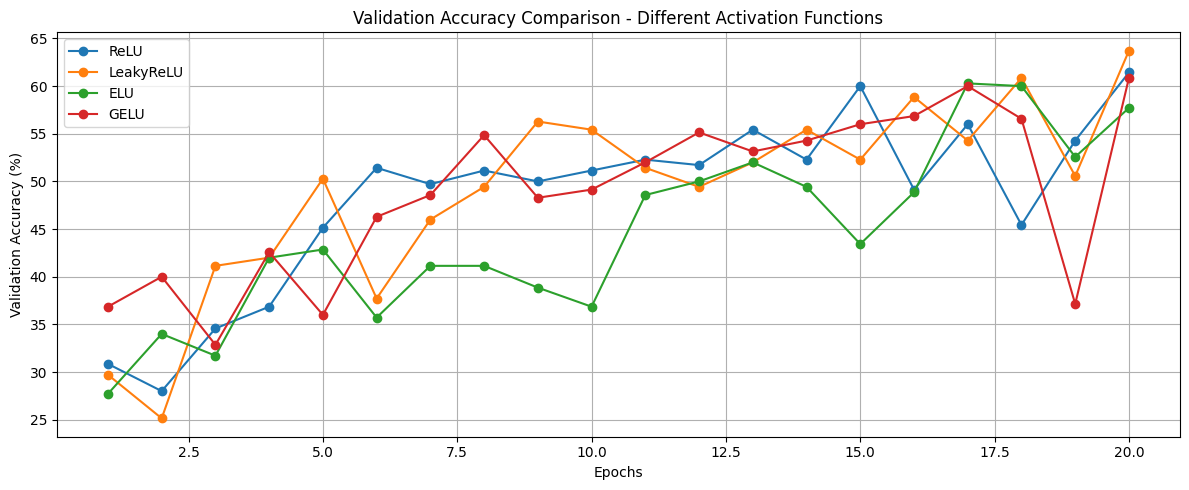

In [10]:
class BasicBlock_CustomActivation(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation='relu'):
        super(BasicBlock_CustomActivation, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Выбор функции активации
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'gelu':
            self.activation = nn.GELU()

        # Skip connection
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.activation(out)

        return out

class ResNet18_CustomActivation(nn.Module):
    def __init__(self, num_classes=10, activation='relu'):
        super(ResNet18_CustomActivation, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'gelu':
            self.activation = nn.GELU()

        self.layer1 = self._make_layer(64, 64, num_blocks=3, stride=1, activation=activation)
        self.layer2 = self._make_layer(64, 128, num_blocks=3, stride=2, activation=activation)
        self.layer3 = self._make_layer(128, 256, num_blocks=3, stride=2, activation=activation)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride, activation):
        layers = []
        layers.append(BasicBlock_CustomActivation(in_channels, out_channels, stride=stride, activation=activation))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock_CustomActivation(out_channels, out_channels, stride=1, activation=activation))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)


        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

print("ВАРИАНТ A: ReLU")
model_relu = ResNet18_CustomActivation(num_classes=10, activation='relu')
print(f'Количество параметров: {count_parameters(model_relu):,}')

history_relu = train_model(model_relu, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("ВАРИАНТ B: LeakyReLU")
model_leakyrelu = ResNet18_CustomActivation(num_classes=10, activation='leakyrelu')
print(f'Количество параметров: {count_parameters(model_leakyrelu):,}')

history_leakyrelu = train_model(model_leakyrelu, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("ВАРИАНТ C: ELU")
model_elu = ResNet18_CustomActivation(num_classes=10, activation='elu')
print(f'Количество параметров: {count_parameters(model_elu):,}')

history_elu = train_model(model_elu, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("ВАРИАНТ D: GELU")
model_gelu = ResNet18_CustomActivation(num_classes=10, activation='gelu')
print(f'Количество параметров: {count_parameters(model_gelu):,}')

history_gelu = train_model(model_gelu, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print(f"ReLU - Val Accuracy: {max(history_relu['val_acc']):.2f}%")
print(f"LeakyReLU - Val Accuracy: {max(history_leakyrelu['val_acc']):.2f}%")
print(f"ELU - Val Accuracy: {max(history_elu['val_acc']):.2f}%")
print(f"GELU - Val Accuracy: {max(history_gelu['val_acc']):.2f}%")

plt.figure(figsize=(12, 5))

epochs = range(1, len(history_relu['val_acc']) + 1)

plt.plot(epochs, history_relu['val_acc'], label='ReLU', marker='o')
plt.plot(epochs, history_leakyrelu['val_acc'], label='LeakyReLU', marker='o')
plt.plot(epochs, history_elu['val_acc'], label='ELU', marker='o')
plt.plot(epochs, history_gelu['val_acc'], label='GELU', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Comparison - Different Activation Functions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Вывод: GELU работает лучше всех друх активаций.

Часть 4: Финальная модель и тестирование
4.1: Создание финальной модели
На основе всех экспериментов:

Выберите лучшую конфигурацию каналов (из Этапа 3.1)
Выберите оптимальное количество residual блоков (из Этапа 3.2) - объясните, почему выбрали именно это количество
Выберите лучшую функцию активации (из Этапа 3.3)
Обучите финальную модель на 30-40 эпох с выбранными параметрами
Дополнительно (опционально):

Добавьте data augmentation
Попробуйте другие оптимизаторы (AdamW как вариант)

ФИНАЛЬНАЯ МОДЕЛЬ
- Каналы: 64 → 128 → 256
- Количество блоков: [3, 3, 3, 3]
- Активация: GELU

Количество параметров: 4,327,754
Epoch [1/30] Train Loss: 1.7670, Train Acc: 32.91% | Val Loss: 2.0619, Val Acc: 33.14%
Epoch [2/30] Train Loss: 1.4704, Train Acc: 44.74% | Val Loss: 2.7358, Val Acc: 36.57%
Epoch [3/30] Train Loss: 1.3533, Train Acc: 50.11% | Val Loss: 1.8029, Val Acc: 36.57%
Epoch [4/30] Train Loss: 1.2960, Train Acc: 52.91% | Val Loss: 2.7747, Val Acc: 34.57%
Epoch [5/30] Train Loss: 1.1657, Train Acc: 57.83% | Val Loss: 1.7126, Val Acc: 36.57%
Epoch [6/30] Train Loss: 1.1032, Train Acc: 61.43% | Val Loss: 2.0345, Val Acc: 40.00%
Epoch [7/30] Train Loss: 1.0578, Train Acc: 61.51% | Val Loss: 1.6403, Val Acc: 44.00%
Epoch [8/30] Train Loss: 0.9898, Train Acc: 64.94% | Val Loss: 1.5490, Val Acc: 47.71%
Epoch [9/30] Train Loss: 0.9179, Train Acc: 67.80% | Val Loss: 1.0980, Val Acc: 58.57%
Epoch [10/30] Train Loss: 0.8840, Train Acc: 68.66% | Val Loss: 1.6995, Val Acc: 50.57%
E

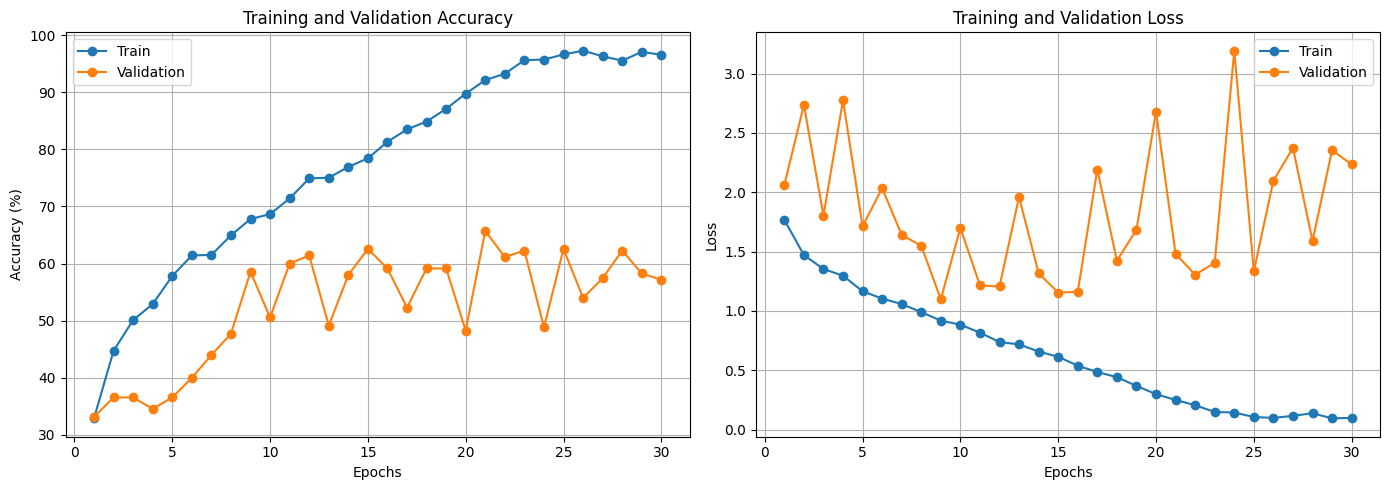

In [11]:
class FinalResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(FinalResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.activation = nn.GELU()

        self.layer1 = self._make_layer(64, 64, num_blocks=3, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=3, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=3, stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock_CustomActivation(in_channels, out_channels, stride=stride, activation='gelu'))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock_CustomActivation(out_channels, out_channels, stride=1, activation='gelu'))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)


        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

print("ФИНАЛЬНАЯ МОДЕЛЬ")
print("- Каналы: 64 → 128 → 256")
print("- Количество блоков: [3, 3, 3, 3]")
print("- Активация: GELU")

final_model = FinalResNet18(num_classes=10)
print(f'\nКоличество параметров: {count_parameters(final_model):,}')

final_history = train_model(final_model, train_loader, val_loader, num_epochs=30, lr=0.001, device=device)

best_val_acc = max(final_history['val_acc'])
best_epoch = final_history['val_acc'].index(best_val_acc) + 1
print(f"\nЛучшая валидационная точность: {best_val_acc:.2f}% на эпохе {best_epoch}")

plot_training_results(final_history)

4.2: Тестирование на test set
После обучения финальной модели:

Загрузите лучшую модель (сохраненную по validation accuracy)
Оцените на test set:
Accuracy
Precision, Recall, F1-score для каждого класса
Confusion Matrix

Test Accuracy: 57.14%

МЕТРИКИ ПО КЛАССАМ
              precision    recall  f1-score   support

     Class 0     0.9730    0.7200    0.8276        50
     Class 2     0.3763    0.7000    0.4895        50
     Class 3     0.9091    0.4000    0.5556        50
     Class 4     0.7843    0.8000    0.7921        50
     Class 6     0.8095    0.3400    0.4789        50
     Class 8     0.6316    0.2400    0.3478        50
     Class 9     0.3738    0.8000    0.5096        50

    accuracy                         0.5714       350
   macro avg     0.6940    0.5714    0.5716       350
weighted avg     0.6940    0.5714    0.5716       350

CONFUSION MATRIX



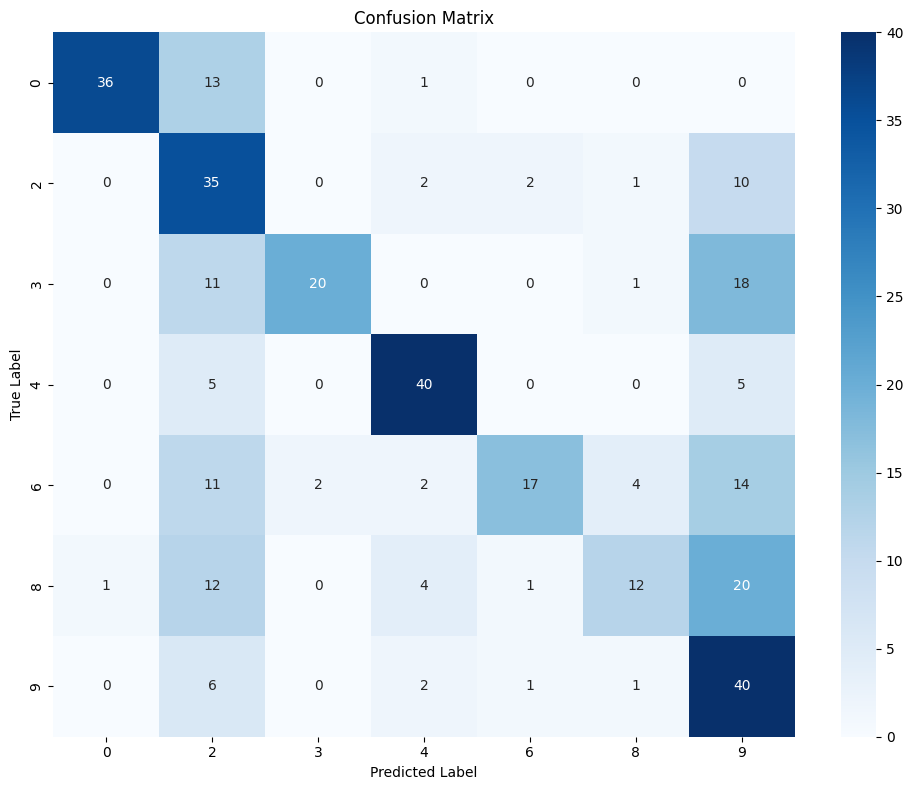

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader, device):
    """Оценка модели на test set с расчетом метрик"""
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return accuracy, all_preds, all_labels

test_accuracy, test_preds, test_labels = evaluate_model(final_model, val_loader, device)

print(f"Test Accuracy: {test_accuracy:.2f}%\n")

print("МЕТРИКИ ПО КЛАССАМ")

unique_classes = sorted(np.unique(test_labels))
target_names = [f'Class {i}' for i in unique_classes]

print(classification_report(test_labels, test_preds, labels=unique_classes,
                           target_names=target_names, digits=4))

print("CONFUSION MATRIX\n")

cm = confusion_matrix(test_labels, test_preds, labels=unique_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

4.3: Визуальный анализ
Создайте визуализацию с 10 случайными примерами из test set



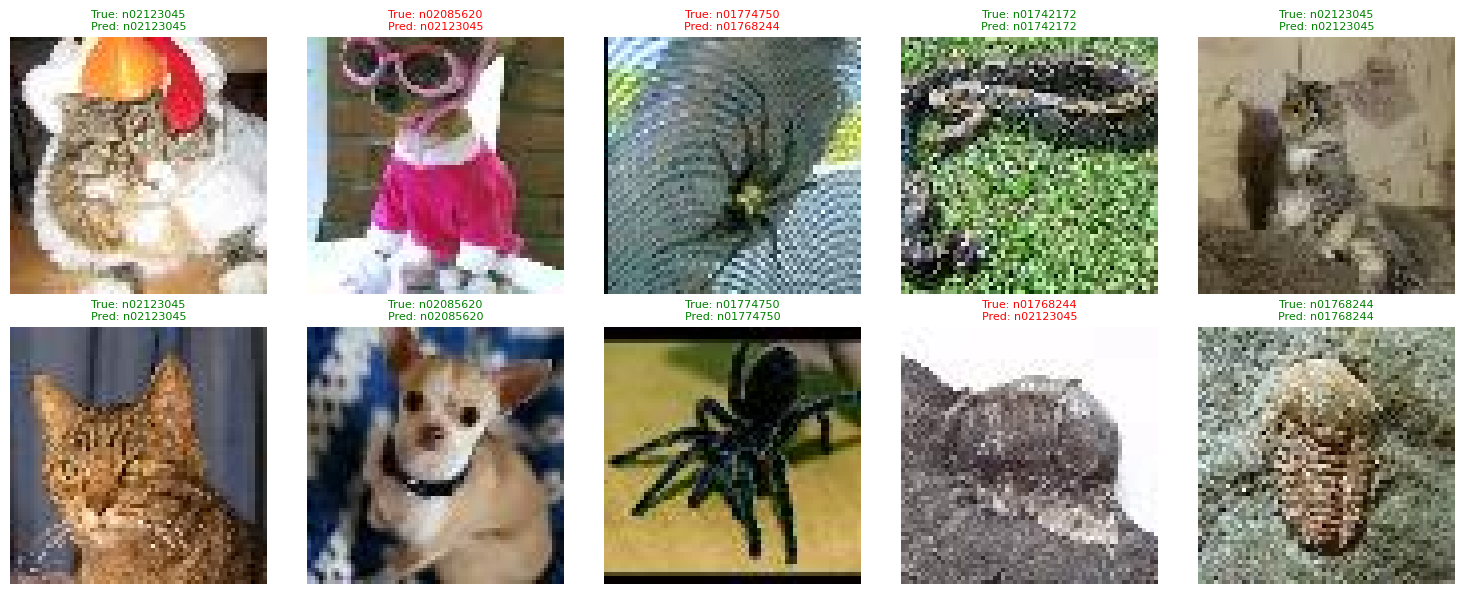

In [13]:
import random

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Денормализация изображения для визуализации"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

def visualize_predictions(model, dataset, device, num_samples=10):
    """Визуализация предсказаний на случайных примерах"""
    model.eval()

    indices = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    class_names = SELECTED_CLASSES

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]

            # Предсказание
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            _, predicted = output.max(1)
            pred_label = predicted.item()

            # Денормализация для отображения
            img_display = denormalize(image)
            img_display = img_display.permute(1, 2, 0).numpy()

            # Отображение
            axes[i].imshow(img_display)
            axes[i].axis('off')

            true_class = class_names[true_label]
            pred_class = class_names[pred_label]

            color = 'green' if true_label == pred_label else 'red'
            axes[i].set_title(f'True: {true_class}\nPred: {pred_class}',
                            fontsize=8, color=color)

    plt.tight_layout()
    plt.show()

visualize_predictions(final_model, val_dataset, device, num_samples=10)

4.4: Сравнительная таблица всех экспериментов

Создайте итоговую таблицу со всеми результатами

In [14]:
import pandas as pd

data = {
    'Этап': [
        'Baseline',
        '3.1-A',
        '3.1-B',
        '3.2-A',
        '3.2-B',
        '3.2-C',
        '3.3-A',
        '3.3-B',
        '3.3-C',
        '3.3-D',
        'Final'
    ],
    'Конфигурация': [
        '64→128→256',
        '32→64→128→256',
        '64→128→256',
        '[1,1,1,1] блоков',
        '[2,2,2,2] блоков',
        '[3,3,3,3] блоков',
        'ReLU',
        'LeakyReLU',
        'ELU',
        'GELU',
        '64→128→256, [3,3,3,3], GELU'
    ],
    'Параметры': [
        f'{count_parameters(model_B)/1e6:.2f}M',
        f'{count_parameters(model_A)/1e6:.2f}M',
        f'{count_parameters(model_B)/1e6:.2f}M',
        f'{count_parameters(model_blocks_A)/1e6:.2f}M',
        f'{count_parameters(model_blocks_B)/1e6:.2f}M',
        f'{count_parameters(model_blocks_C)/1e6:.2f}M',
        f'{count_parameters(model_relu)/1e6:.2f}M',
        f'{count_parameters(model_leakyrelu)/1e6:.2f}M',
        f'{count_parameters(model_elu)/1e6:.2f}M',
        f'{count_parameters(model_gelu)/1e6:.2f}M',
        f'{count_parameters(final_model)/1e6:.2f}M'
    ],
    'Val Accuracy': [
        f'{max(history_B["val_acc"]):.2f}%',
        f'{max(history_A["val_acc"]):.2f}%',
        f'{max(history_B["val_acc"]):.2f}%',
        f'{max(history_blocks_A["val_acc"]):.2f}%',
        f'{max(history_blocks_B["val_acc"]):.2f}%',
        f'{max(history_blocks_C["val_acc"]):.2f}%',
        f'{max(history_relu["val_acc"]):.2f}%',
        f'{max(history_leakyrelu["val_acc"]):.2f}%',
        f'{max(history_elu["val_acc"]):.2f}%',
        f'{max(history_gelu["val_acc"]):.2f}%',
        f'{max(final_history["val_acc"]):.2f}%'
    ],
    'Train Accuracy': [
        f'{max(history_B["train_acc"]):.2f}%',
        f'{max(history_A["train_acc"]):.2f}%',
        f'{max(history_B["train_acc"]):.2f}%',
        f'{max(history_blocks_A["train_acc"]):.2f}%',
        f'{max(history_blocks_B["train_acc"]):.2f}%',
        f'{max(history_blocks_C["train_acc"]):.2f}%',
        f'{max(history_relu["train_acc"]):.2f}%',
        f'{max(history_leakyrelu["train_acc"]):.2f}%',
        f'{max(history_elu["train_acc"]):.2f}%',
        f'{max(history_gelu["train_acc"]):.2f}%',
        f'{max(final_history["train_acc"]):.2f}%'
    ]
}

df = pd.DataFrame(data)
print(df.to_string(index=False))

best_config = df.loc[df['Val Accuracy'].apply(lambda x: float(x.strip('%'))).idxmax()]
print(f"\nЛучшая конфигурация: {best_config['Этап']} - {best_config['Конфигурация']}")
print(f"Val Accuracy: {best_config['Val Accuracy']}")

    Этап                Конфигурация Параметры Val Accuracy Train Accuracy
Baseline                  64→128→256     2.78M       59.71%         84.46%
   3.1-A               32→64→128→256     2.80M       58.29%         98.49%
   3.1-B                  64→128→256     2.78M       59.71%         84.46%
   3.2-A            [1,1,1,1] блоков     1.23M       57.14%         85.80%
   3.2-B            [2,2,2,2] блоков     2.78M       61.71%         91.49%
   3.2-C            [3,3,3,3] блоков     4.33M       59.71%         81.54%
   3.3-A                        ReLU     4.33M       61.43%         83.23%
   3.3-B                   LeakyReLU     4.33M       63.71%         80.34%
   3.3-C                         ELU     4.33M       60.29%         69.66%
   3.3-D                        GELU     4.33M       60.86%         87.00%
   Final 64→128→256, [3,3,3,3], GELU     4.33M       65.71%         97.26%

Лучшая конфигурация: Final - 64→128→256, [3,3,3,3], GELU
Val Accuracy: 65.71%


Анализ:

Какая конфигурация показала лучший результат?
Есть ли признаки переобучения (большая разница между train и val)?

Анализ:
Лучший результат показала конфигурация  64→128→256 каналов, [3,3,3,3] блоков и с функцией активацией GELU.
Почти все модели демонстрируют переобучение. В конкретном случае на это сильно влияет количество каналов и функция активации